In [35]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [52]:

class VisualizePreTrainedLLMResults:
    def __init__(self, json_files):
        self.json_files = json_files

    def load_metrics(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def analyze_metrics(self, metrics, model_name):
        epochs = [m['epoch'] for m in metrics['epoch_metrics']]
        train_losses = [m['train_loss'] for m in metrics['epoch_metrics']]
        val_losses = [m['val_loss'] for m in metrics['epoch_metrics']]
        test_losses = [m['test_loss'] for m in metrics['epoch_metrics']]
        train_accuracies = [m['train_accuracy'] for m in metrics['epoch_metrics']]
        val_accuracies = [m['val_accuracy'] for m in metrics['epoch_metrics']]
        test_accuracies = [m['test_accuracy'] for m in metrics['epoch_metrics']]
        train_precisions = [m['train_precision'] for m in metrics['epoch_metrics']]
        val_precisions = [m['val_precision'] for m in metrics['epoch_metrics']]
        test_precisions = [m['test_precision'] for m in metrics['epoch_metrics']]
        train_recalls = [m['train_recall'] for m in metrics['epoch_metrics']]
        val_recalls = [m['val_recall'] for m in metrics['epoch_metrics']]
        test_recalls = [m['test_recall'] for m in metrics['epoch_metrics']]
        train_f1s = [m['train_f1'] for m in metrics['epoch_metrics']]
        val_f1s = [m['val_f1'] for m in metrics['epoch_metrics']]
        test_f1s = [m['test_f1'] for m in metrics['epoch_metrics']]
        train_class_avg_accuracies = [m['train_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        val_class_avg_accuracies = [m['val_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        test_class_avg_accuracies = [m['test_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        roc_aucs = [m['roc_auc'] for m in metrics['epoch_metrics']]
        pr_aucs = [m['pr_auc'] for m in metrics['epoch_metrics']]

        model_display_name = model_name.split('/')[-1]

        # Calculate the average final metrics
        final_test_class_avg_accuracy = np.mean(test_class_avg_accuracies)
        final_test_precision = np.mean(test_precisions)
        final_test_recall = np.mean(test_recalls)
        final_test_f1 = np.mean(test_f1s)
        final_test_roc_auc = np.mean(roc_aucs)
        final_test_pr_auc = np.mean(pr_aucs)

        print(f"\nModel: {model_display_name}")
        print(f"Best Parameters: {metrics['best_params']}")
        print(f"Final Test Loss: {metrics['test_loss']}")
        print(f"Final Test Class Avg Accuracy: {final_test_class_avg_accuracy}")
        print(f"Final Test Precision: {final_test_precision}")
        print(f"Final Test Recall: {final_test_recall}")
        print(f"Final Test F1 Score: {final_test_f1}")

        plt.figure(figsize=(18, 12))

        colors = sns.color_palette("husl", 4)  # Four colors for train, validation, test, and ROC/PR AUC
        final_colors = sns.color_palette("husl", 4, desat=0.5)  # Distinct colors for final metrics

        plt.subplot(2, 3, 1)
        sns.violinplot(data=[train_precisions, val_precisions, test_precisions], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Precision')
        plt.title(f'{model_display_name} - Precision')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 2)
        sns.violinplot(data=[train_class_avg_accuracies, val_class_avg_accuracies, test_class_avg_accuracies], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Class Accuracy Avg')
        plt.title(f'{model_display_name} - Class Accuracy Avg')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 3)
        sns.violinplot(data=[train_losses, val_losses, test_losses], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Loss')
        plt.title(f'{model_display_name} - Loss')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 4)
        sns.violinplot(data=[train_recalls, val_recalls, test_recalls], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Recall')
        plt.title(f'{model_display_name} - Recall')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 5)
        sns.violinplot(data=[train_f1s, val_f1s, test_f1s], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('F1 Score')
        plt.title(f'{model_display_name} - F1 Score')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 6)
        metrics_names = ['Accuracy Avg', 'Precision', 'Recall', 'F1 Score']
        final_metrics = [final_test_class_avg_accuracy, final_test_precision, final_test_recall, final_test_f1]
        final_metrics_df = pd.DataFrame({'Metrics': metrics_names, 'Values': final_metrics, 'Hue': metrics_names})
        sns.barplot(x='Metrics', y='Values', hue='Hue', data=final_metrics_df, palette=final_colors, dodge=False, legend=False)
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title(f'{model_display_name} - Final Test Metrics')
        plt.ylim(0, 1)
        for i, v in enumerate(final_metrics):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

        # Overall legend
        legend_handles = [Patch(color=colors[0], label='Train'), Patch(color=colors[1], label='Validation'), Patch(color=colors[2], label='Test')]
        plt.figlegend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)

        plt.tight_layout()
        plt.savefig(f'{model_display_name}_metrics.png')
        plt.show()

    def run_analysis(self):
        metrics_data = []

        for file in self.json_files:
            file_path = os.path.join('./', file)
            if os.path.exists(file_path):
                metrics = self.load_metrics(file_path)
                model_name = file.split('metrics_')[1].split('.json')[0]  # Get the full model name
                self.analyze_metrics(metrics, model_name)
                metrics_data.append((model_name, metrics))
            else:
                print(f"File {file_path} does not exist.")

        # Generate a consolidated report
        report = {
            model: {
                "best_params": metrics["best_params"],
                "final_metrics": {
                    "test_loss": metrics["test_loss"],
                    "class_avg_accuracy": np.mean([m['test_class_avg_accuracy'] for m in metrics['epoch_metrics']]),
                    "precision": np.mean([m['test_precision'] for m in metrics['epoch_metrics']]),
                    "recall": np.mean([m['test_recall'] for m in metrics['epoch_metrics']]),
                    "f1": np.mean([m['test_f1'] for m in metrics['epoch_metrics']]),
                    "roc_auc": np.mean([m['roc_auc'] for m in metrics['epoch_metrics']]),
                    "pr_auc": np.mean([m['pr_auc'] for m in metrics['epoch_metrics']])
                }
            }
            for model, metrics in metrics_data
        }

        with open('consolidated_report.json', 'w') as f:
            json.dump(report, f, indent=4)

        print("\nConsolidated report saved as 'consolidated_report.json'")





Model: DeepChem_ChemBERTa-10M-MLM
Best Parameters: {'learning_rate': 1.9000194276448415e-05, 'epochs': 6}
Final Test Loss: 0.683770796726266
Final Test Class Avg Accuracy: 0.8837063447447912
Final Test Precision: 0.8942934735831689
Final Test Recall: 0.5153208175729603
Final Test F1 Score: 0.6315528731113788


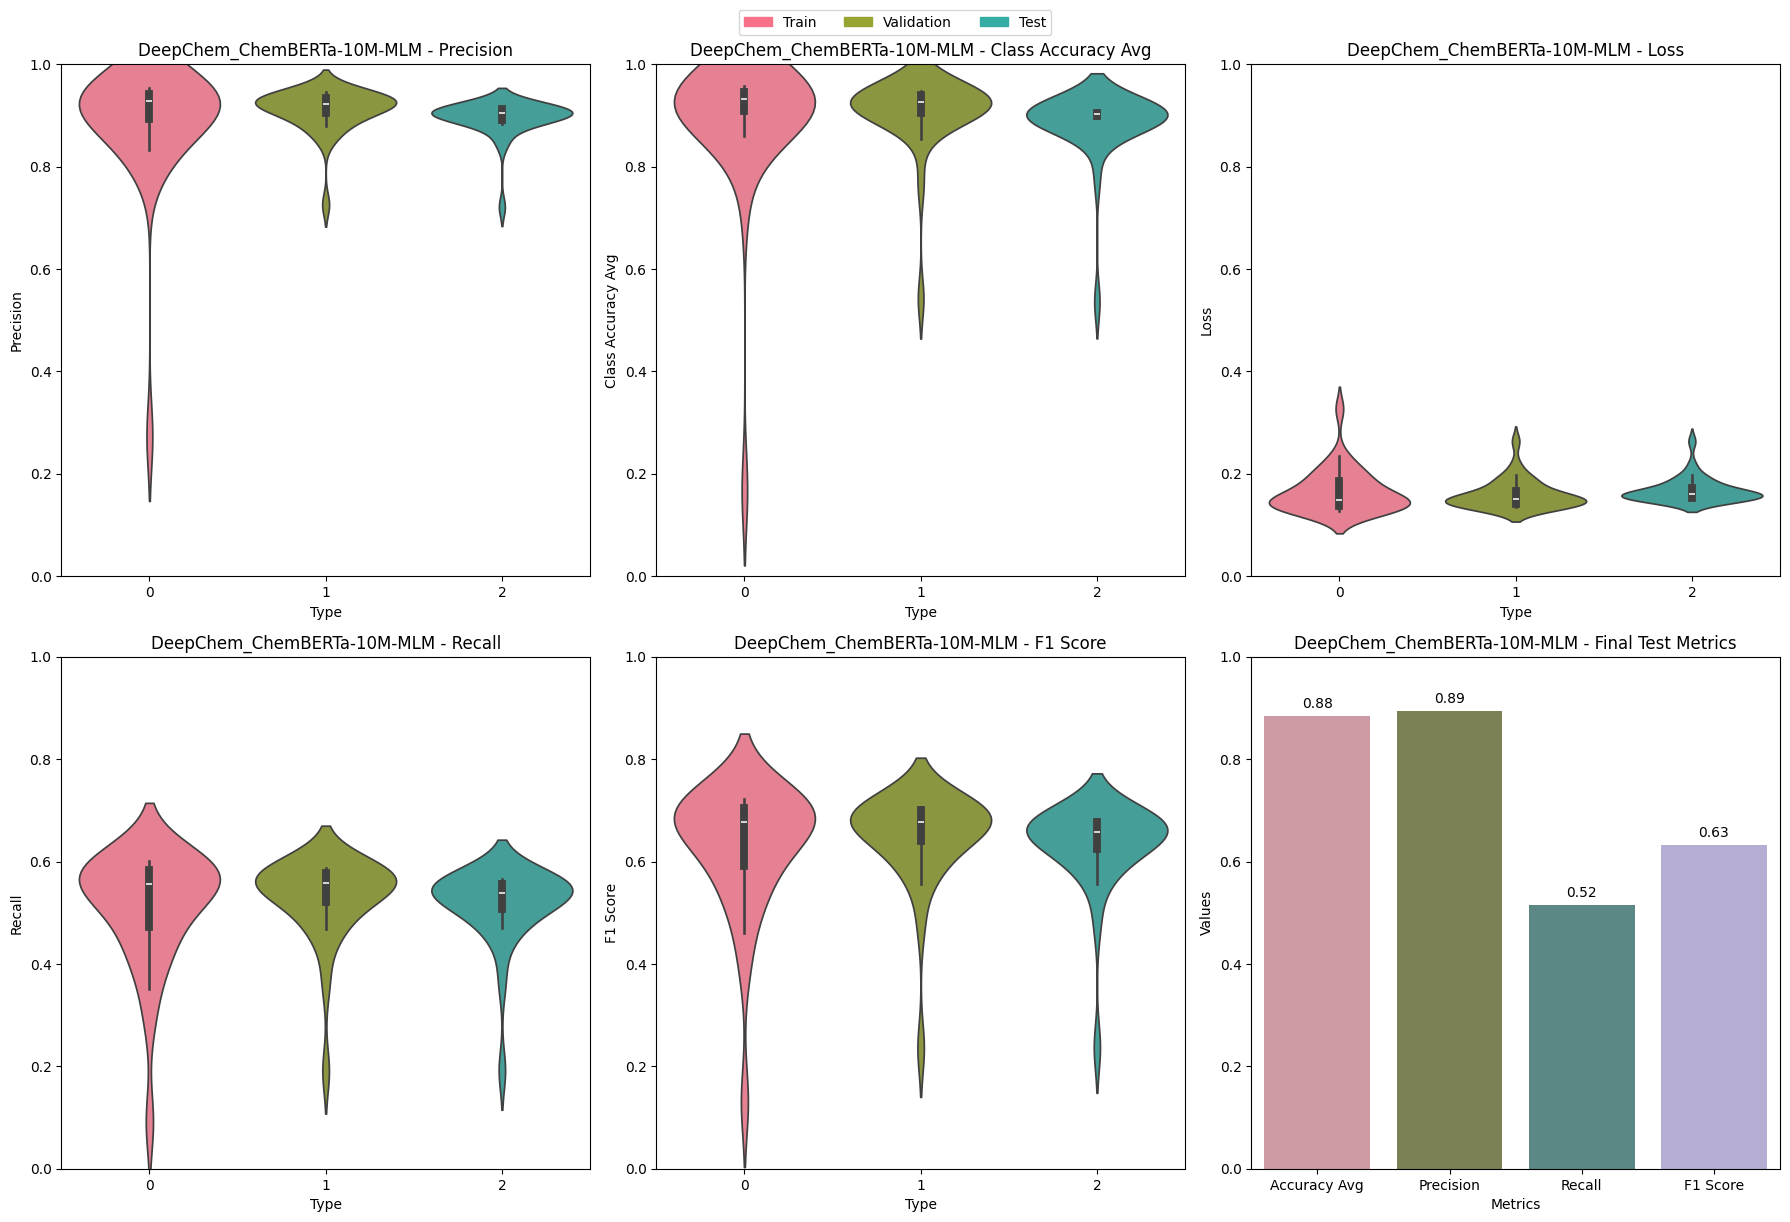


Model: DeepChem_ChemBERTa-10M-MTR
Best Parameters: {'learning_rate': 1.79312375392709e-05, 'epochs': 5}
Final Test Loss: 0.6660015896224203
Final Test Class Avg Accuracy: 0.8803240195226284
Final Test Precision: 0.8830124462189356
Final Test Recall: 0.48186764756914313
Final Test F1 Score: 0.599949455098206


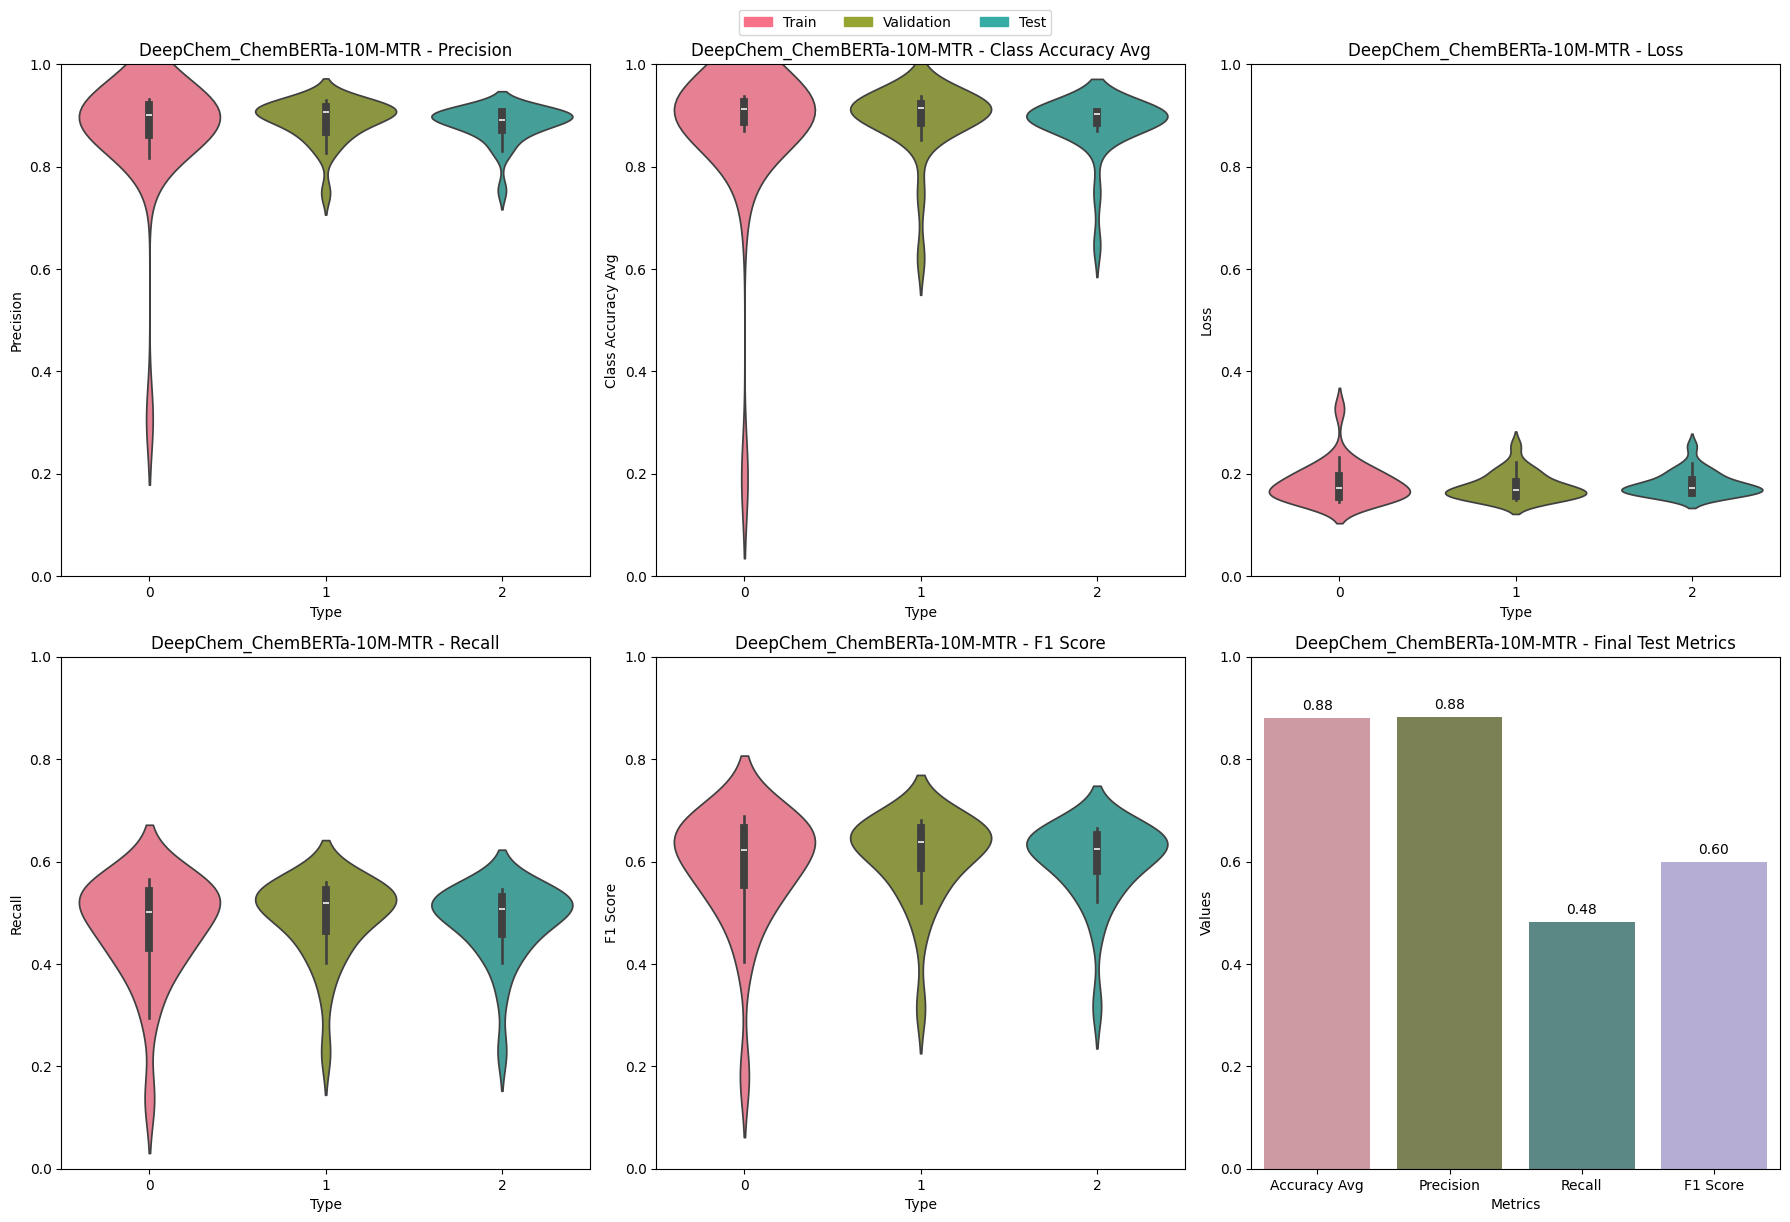


Consolidated report saved as 'consolidated_report.json'


In [53]:
if __name__ == "__main__":
    json_files = ['/content/metrics_DeepChem_ChemBERTa-10M-MLM.json', '/content/metrics_DeepChem_ChemBERTa-10M-MTR.json']
    visualizer = VisualizePreTrainedLLMResults(json_files)
    visualizer.run_analysis()


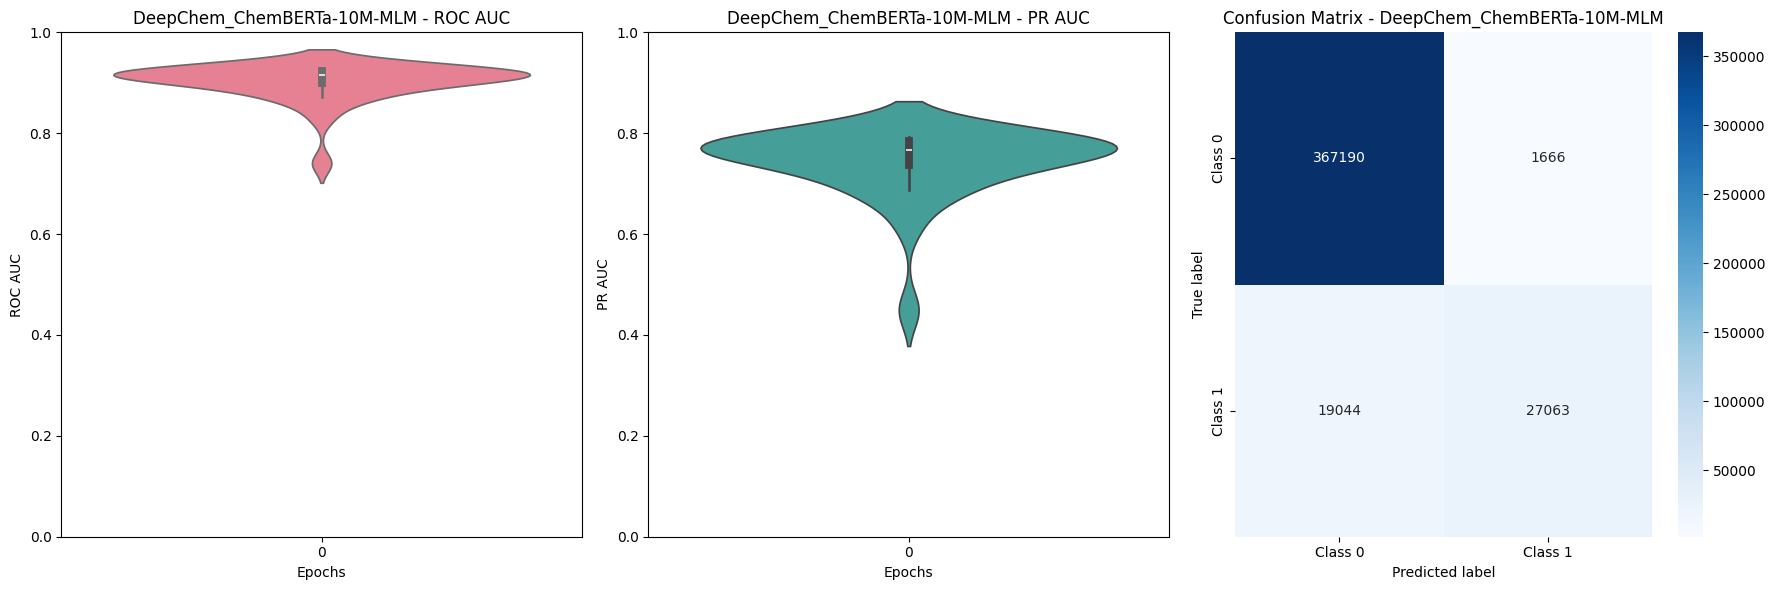

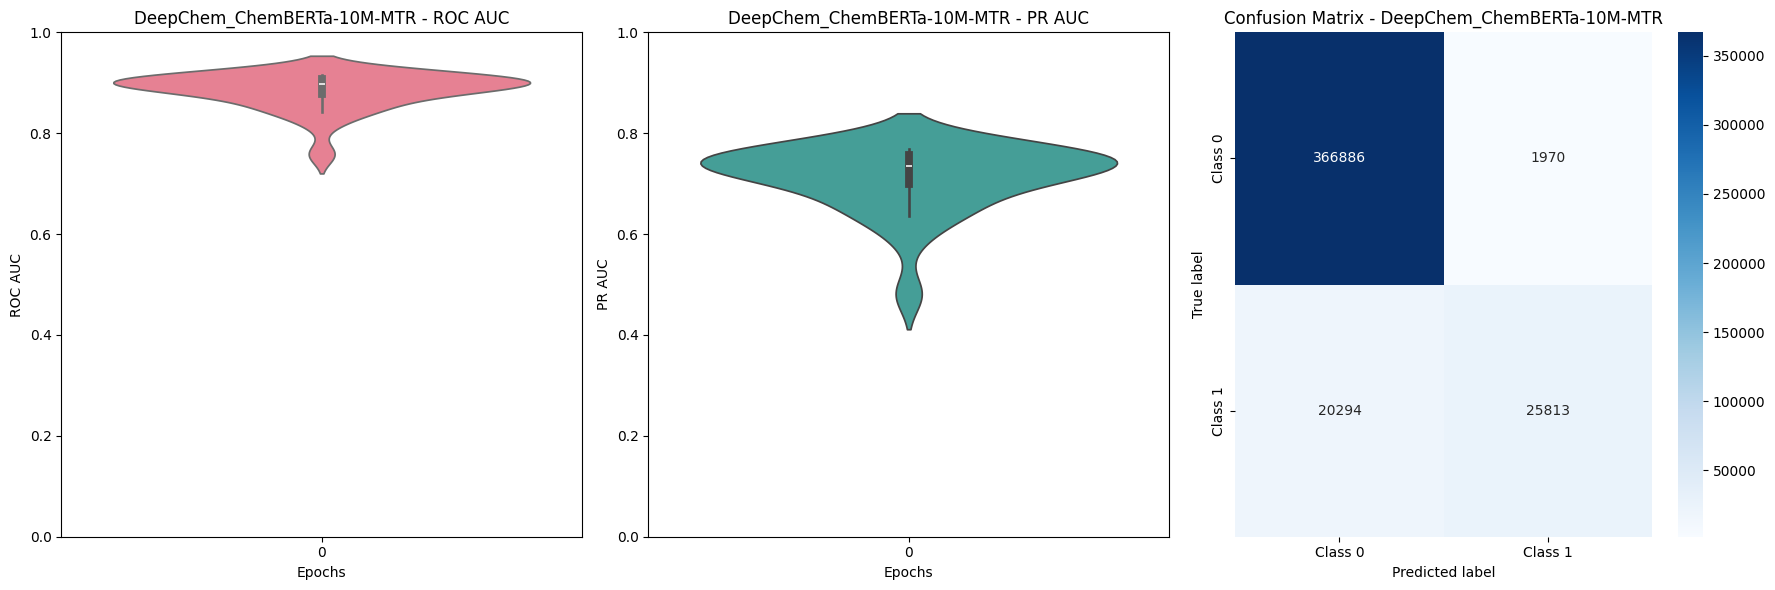

In [49]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

class VisualizeROCAndCM:
    def __init__(self, json_files):
        self.json_files = json_files

    def load_metrics(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def plot_violin(self, data, title, ylabel, palette):
        sns.violinplot(data=[data], palette=[palette])
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.ylim(0, 1)

    def plot_confusion_matrix(self, cm, classes, model_name):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f'Confusion Matrix - {model_name}')

    def analyze_metrics(self, metrics, model_name):
        roc_aucs = [m['roc_auc'] for m in metrics['epoch_metrics']]
        pr_aucs = [m['pr_auc'] for m in metrics['epoch_metrics']]
        model_display_name = model_name.split('/')[-1]

        # Select the best epoch based on validation F1 score
        best_epoch_metric = max(metrics['epoch_metrics'], key=lambda x: x['val_f1'])
        cm = np.sum(np.array(best_epoch_metric['conf_matrix']), axis=0)
        classes = [f'Class {i}' for i in range(cm.shape[0])]

        plt.figure(figsize=(18, 6))

        colors = sns.color_palette("husl", 2)  # Two colors for ROC AUC and PR AUC

        # ROC AUC plot as violin plot with a distinct color
        plt.subplot(1, 3, 1)
        self.plot_violin(roc_aucs, f'{model_display_name} - ROC AUC', 'ROC AUC', colors[0])

        # PR AUC plot as violin plot with a distinct color
        plt.subplot(1, 3, 2)
        self.plot_violin(pr_aucs, f'{model_display_name} - PR AUC', 'PR AUC', colors[1])

        # Confusion Matrix
        plt.subplot(1, 3, 3)
        self.plot_confusion_matrix(cm, classes, model_display_name)

        plt.tight_layout()
        plt.savefig(f'{model_display_name}_roc_pr_auc_conf_matrix.png')
        plt.show()

    def run_analysis(self):
        for file in self.json_files:
            file_path = os.path.join('./', file)
            if os.path.exists(file_path):
                metrics = self.load_metrics(file_path)
                model_name = file.split('metrics_')[1].split('.json')[0]
                self.analyze_metrics(metrics, model_name)
            else:
                print(f"File {file_path} does not exist.")

if __name__ == "__main__":
    json_files = ['/content/metrics_DeepChem_ChemBERTa-10M-MLM.json', '/content/metrics_DeepChem_ChemBERTa-10M-MTR.json']
    visualizer = VisualizeROCAndCM(json_files)
    visualizer.run_analysis()
